In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

In [3]:

def make_name(s1,s2): 
    out_name = ""
    if not (pd.isna(s1) and pd.isna(s2)): 
        out_name = "_".join( [e for e in [s1,s2] if not pd.isna(e)])
    return out_name
def filter_columns(col_names,pattern,exclude_capita=True):
    if exclude_capita: 
        return [ e for e in col_names if e.startswith(pattern) and 'capita' not in e]
    else: 
        return [ e for e in col_names if e.startswith(pattern) ]

In [4]:
data = pd.read_excel("./2016cityandcountyenergyprofiles(1).xlsb",sheet_name='County',skiprows=4)
col_info = pd.read_excel("./2016cityandcountyenergyprofiles(1).xlsb",sheet_name='County',nrows=4)
#use this to tell if its residential, industrial or other 
column_identity = col_info.iloc[[0,1],:]
#iterate through all the column names and make them be "residential_consumpition","industrial_consumption" etc 
name_cats = list() 
for col_names in col_info:
    col = col_info[col_names] 
    n1 = col.iloc[0] 
    n2 = col.iloc[1] 
    new_name = make_name(n1,n2)
    name_cats.append(new_name)
#define the actual new neames

new_name = [ f"{a}_{b}" if a  else b for a,b in zip(name_cats,data.keys().to_list()) ] 
#replace the column names 
data.columns = new_name

In [5]:
doe_map = {e['state_id']:e['doe_climate_zone'] for i,e in data.iterrows()}

In [6]:
cols = sorted(data.keys())
reduction_paris = [
    ('Commercial_Electricity_Consume',  filter_columns(cols,'Commercial_Electricity_consumption')),
    ('Commercial_NaturalGas_Consume', filter_columns(cols,'Commercial_Natural Gas_consumption (TcF)')),
    ('Industrial_Electricity_Consume',[e for e in cols if filter_columns(cols,'Industry_Electricity_consumption (MWh)')]),
    ("Industrial_NaturalGas_Consume",["Industry_Natural Gas_consumption (TcF).3"]),
    ("On Road Diesel_Consume",['On Road Transportation_Diesel_consumption (gallons).1']),
    ("On Road Gasoline_Consume",["On Road Transportation_Gasoline_consumption (gallons)"]),
    ("Residential_Electricity_Consume",['Residential_Electricity_consumption (MWh)']),
    ("Residential_NaturalGas_Consume",['Residential_Natural Gas_consumption (TcF)']),
    ]
for n,e in reduction_paris: 
    data[n] = data[e].sum(axis=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  del sys.path[0]


In [7]:
consume_names = [e[0] for e in reduction_paris ]

In [8]:
data['total_consume'] = data[[e[0] for e in reduction_paris]].sum(axis=1)

In [10]:
col_name_paris = [
    ('Gasoline of On Road Transportation','On-road Transportation_Gasoline_GHG emissions mtons CO2e.6'),
    ('Diesel of On Road Transportation', 'On-road Transportation_Gasoline_GHG emissions mtons CO2e.6'),
    ('Electricity of Residential','Residential_Electricity_GHG emissions mtons CO2e'),
    ('Natural Gas of Residential', 'Residential_Natural Gas_GHG emissions mtons CO2e.1'),
    ('Electricity Commercial','Commercial_Electricity_GHG emissions mtons CO2e.2'),
    ('Natural Gas Commerical ','Commercial_Natural Gas_GHG emissions mtons CO2e.3'),
    ('Electricity Industry','Industry_Electricity_GHG emissions mtons CO2e.4'),
    ('Natural Gas','Industry_Natural Gas_GHG emissions mtons CO2e.5'),
    ('Total emissions','total_emissions')


]
emi_cols = [e for e in data if 'GHG emissions' in e ] 
data['total_emissions'] = data[emi_cols].sum(axis=1)

In [34]:
from collections import defaultdict
#derive the total number of expenditures . Group by expenditure category 
expi_list = [ e for e in sorted(data.keys()) if len(e.split("_"))>2  and 'expenditures' in e  and 'captia' not in e] 
expi_cats = ["_".join(e.split('_')[0:2])+'_expenditure_redux' for e in expi_list  if not ('capita'in e)]
expi_d = defaultdict(list) 
for k,v in zip(expi_cats,expi_list): 
    if 'capita' in v: 
        continue 
    expi_d[k].append(v)
#do the actual actulation 
for k,v in expi_d.items(): 
    data[k] = data[v].sum(axis=1)
data['total_expenditure'] = data[list(expi_d.keys())].sum(axis=1)

['Commercial_Electricity_expenditure_redux',
 'Commercial_Natural Gas_expenditure_redux',
 'Industry_Electricity_expenditure_redux',
 'Industry_Natural Gas_expenditure_redux',
 'Residential_Electricity_expenditure_redux',
 'Residential_Natural Gas_expenditure_redux']

In [11]:
import os 
os.makedirs('./figure1_content/',exist_ok=True)

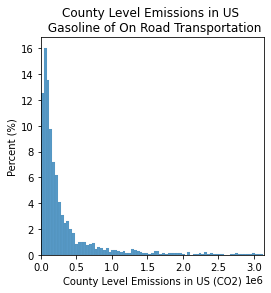

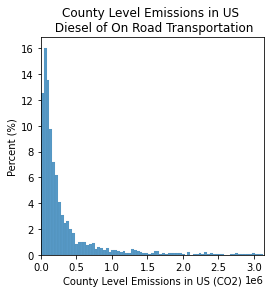

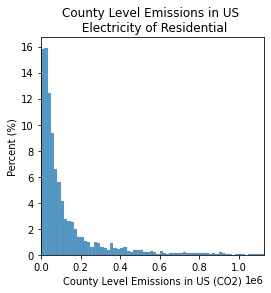

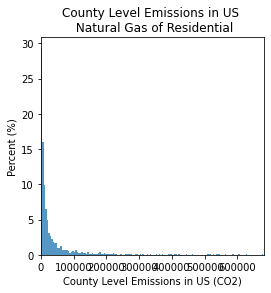

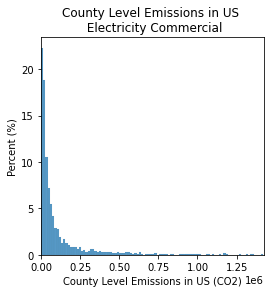

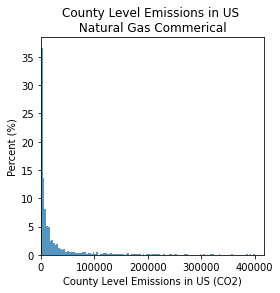

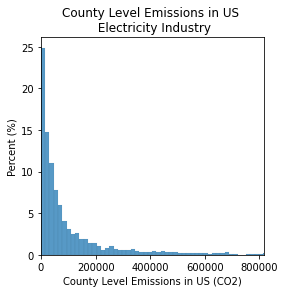

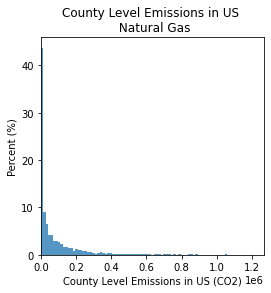

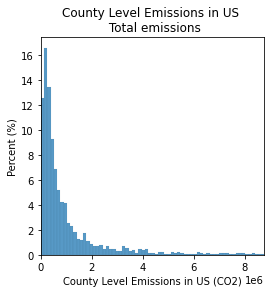

In [12]:
for  i,(name , icol) in enumerate(col_name_paris): 
    plt.figure(figsize=(4,4))
    data_stats=  data[icol].describe()
    mu = data_stats['mean']
    std = data_stats['std']  
    sns.histplot(data=data,x=icol,stat='percent')
    plt.xlim([0, mu + 2*std]) #do this so data is more readable 
    plt.title(f"County Level Emissions in US \n {name}") 
    plt.xlabel("County Level Emissions in US (CO2)")
    plt.ylabel("Percent (%)")
    save_name = name.replace(" ","_")
    plt.savefig(f"./figure1_content/figure1_county_{save_name}_use.png")


In [13]:

os.makedirs('./figure2_content/',exist_ok=True)

In [14]:
climate_map = {1:'Very-Hot', 2:'Hot', 3:'Warm', 4:'Mixed', 5:'Cool', 6:'Cold', 7:'Very-Cold', 8:'Subarctic'}
climate_order = [(v,k) for k,v in climate_map.items()] 
climate_order = sorted(climate_order,key=lambda x: x[1])
climate_order = [e[0] for e in climate_order]

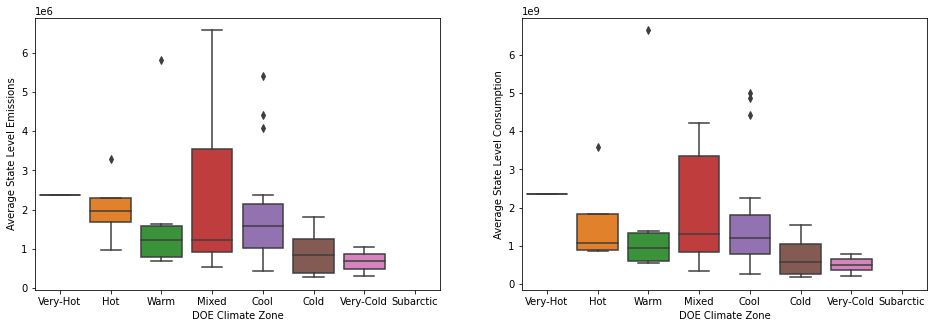

In [15]:

os.makedirs('./figure0_boxplots_overall',exist_ok=True) 
col_name_pairs = [('Emissions','total_emissions'),('Consumption','total_consume')]
fig,axes = plt.subplots(1,2,figsize=(16,5))
axes = axes.flatten()
for  i,(name , icol) in enumerate(col_name_pairs): 
    state_data = data.groupby(by='state_id')
    info = list() 
    for n,e in state_data: 
        s = {} 
        s['state_id'] = n
        s[name]=  e[icol].mean()  
        s['doe_zone']=  climate_map[e['doe_climate_zone'].iloc[0] ]
        info.append(s) 
    plot_df = pd.DataFrame(info)
    sns.boxplot(data=plot_df,x='doe_zone',y=name,order=climate_order,ax=axes[i])
    #plt.title(f"Average State {name} per DOE Climate Zone") 
    axes[i].set_ylabel(f"Average State Level {name}")
    axes[i].set_xlabel("DOE Climate Zone")
    save_name = name.replace(" ","_")
    #plt.savefig(f"./figure0_boxplots_overall/figure0_{save_name}_use_doe.png")

In [16]:
col_name_pairs= [
    ('Total emissions','total_emissions'),
    ('Gasoline of On Road Transportation','On-road Transportation_Gasoline_GHG emissions mtons CO2e.6'),
    ('Diesel of On Road Transportation', 'On-road Transportation_Gasoline_GHG emissions mtons CO2e.6'),
    ('Electricity of Residential','Residential_Electricity_GHG emissions mtons CO2e'),
    ('Natural Gas of Residential', 'Residential_Natural Gas_GHG emissions mtons CO2e.1'),
    ('Electricity Commercial','Commercial_Electricity_GHG emissions mtons CO2e.2'),
    ('Natural Gas Commercial ','Commercial_Natural Gas_GHG emissions mtons CO2e.3'),
    ('Electricity Industry','Industry_Electricity_GHG emissions mtons CO2e.4'),
    ('Natural Gas','Industry_Natural Gas_GHG emissions mtons CO2e.5'),

]

In [17]:
sns.boxplot

<function seaborn.categorical.boxplot(data=None, *, x=None, y=None, hue=None, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, width=0.8, dodge=True, fliersize=5, linewidth=None, whis=1.5, ax=None, **kwargs)>

Text(0.5, 0.98, 'Average GHG Emissions across DOE By:')

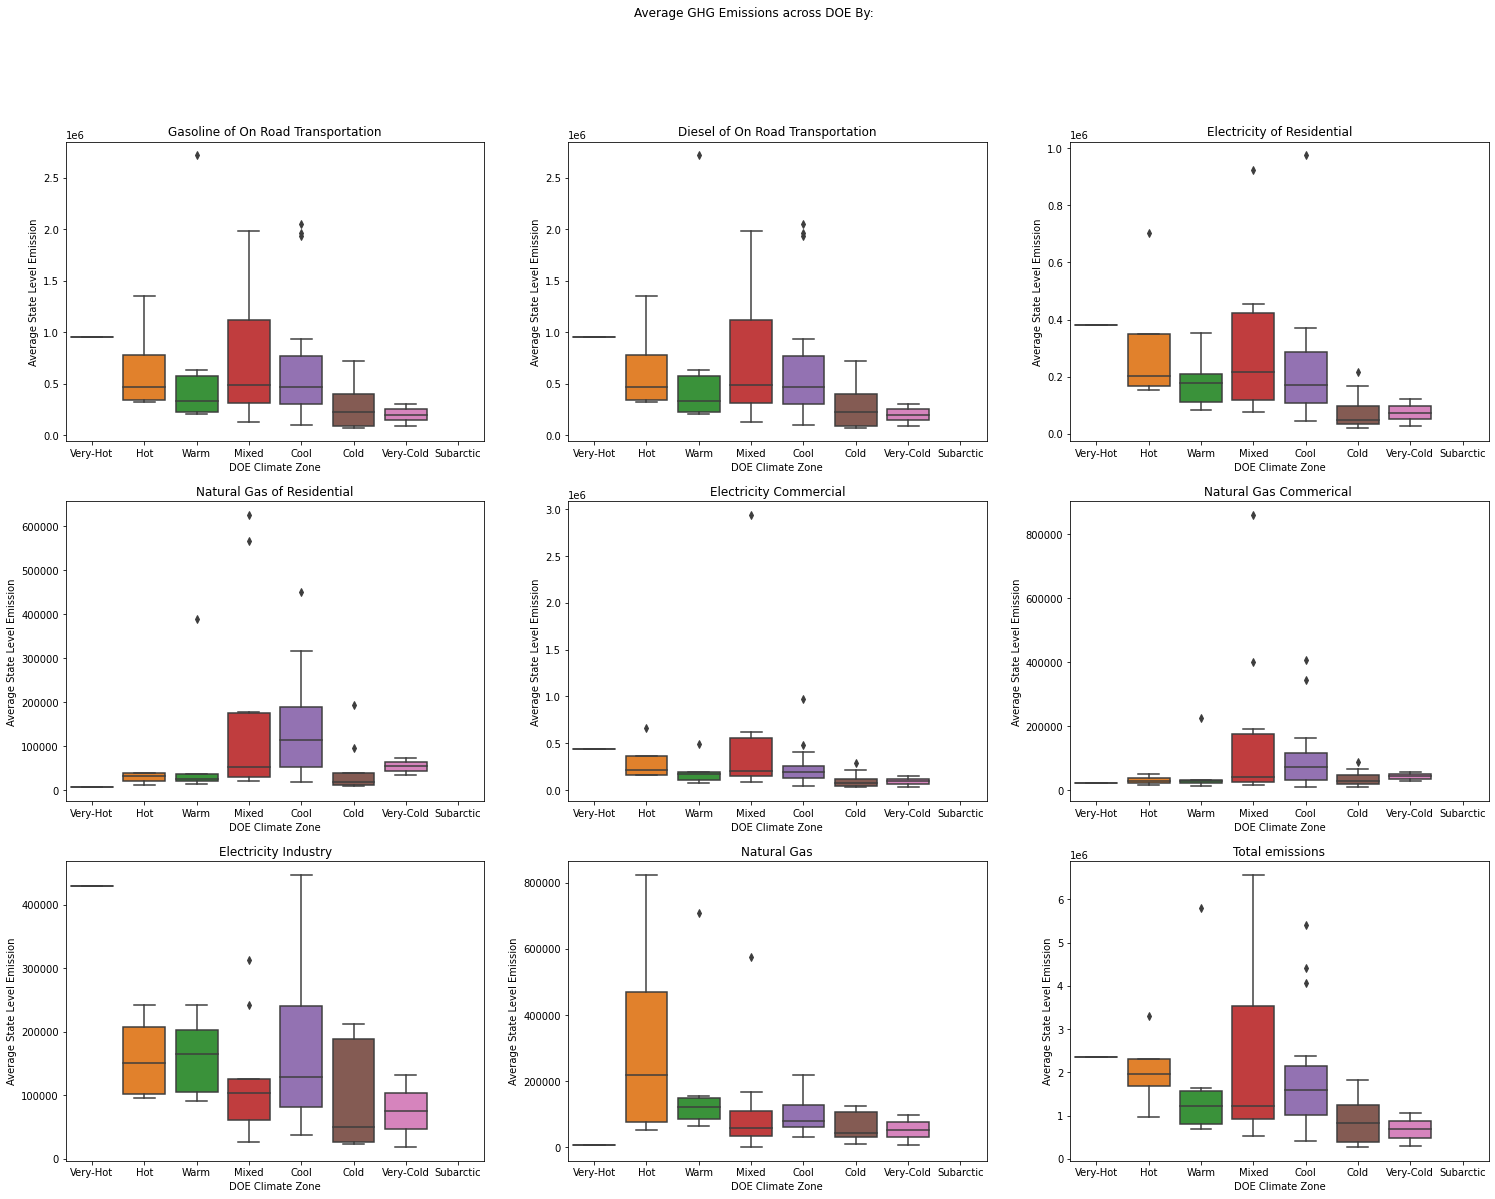

In [18]:
#Do  emisisons plot
fig,axes = plt.subplots(3,3,figsize=(8.5*3,6.25*3))
axes = axes.flatten()
for  i,(name , icol) in enumerate(col_name_paris): 
    state_data = data.groupby(by='state_id')
    info = list() 
    for n,e in state_data: 
        s = {} 
        s['state_id'] = n
        s['avg_emission']=  e[icol].mean()  
        s['doe_zone']=  climate_map[e['doe_climate_zone'].iloc[0] ]
        info.append(s) 
    plot_df = pd.DataFrame(info)
    sns.boxplot(data=plot_df,x='doe_zone',y='avg_emission',order=climate_order,ax=axes[i])
    axes[i].set_title(f"{name}") 
    axes[i].set_ylabel("Average State Level Emission")
    axes[i].set_xlabel("DOE Climate Zone")
fig.suptitle("Average GHG Emissions across DOE By:")



In [19]:
consume_names

['Commercial_Electricity_Consume',
 'Commercial_NaturalGas_Consume',
 'Industrial_Electricity_Consume',
 'Industrial_NaturalGas_Consume',
 'On Road Diesel_Consume',
 'On Road Gasoline_Consume',
 'Residential_Electricity_Consume',
 'Residential_NaturalGas_Consume']

Text(0.5, 0.98, 'Average Consumption across DOE By:')

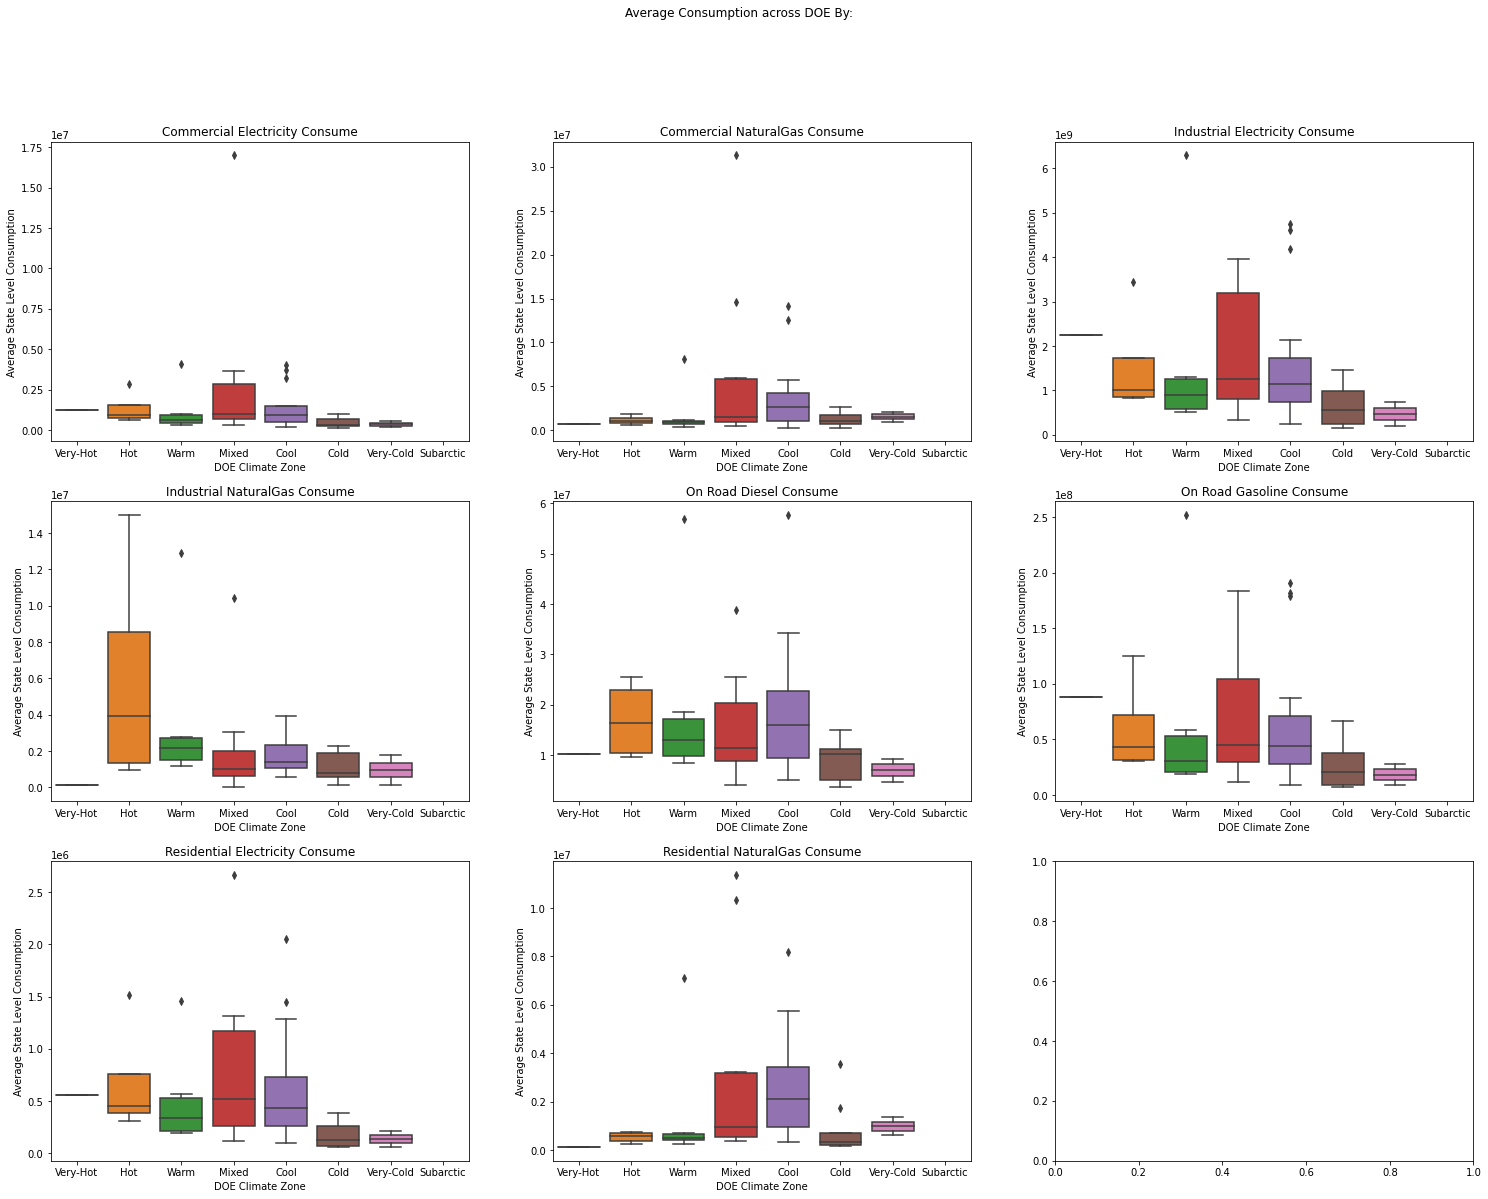

In [20]:

fig,axes = plt.subplots(3,3,figsize=(8.5*3,6.25*3))
axes = axes.flatten()
for  i,( icol) in enumerate(consume_names): 
    name = icol
    state_data = data.groupby(by='state_id')
    info = list() 
    for n,e in state_data: 
        s = {} 
        s['state_id'] = n
        s['avg_emission']=  e[icol].mean()  
        s['doe_zone']=  climate_map[e['doe_climate_zone'].iloc[0] ]
        info.append(s) 
    plot_df = pd.DataFrame(info)
    sns.boxplot(data=plot_df,x='doe_zone',y='avg_emission',order=climate_order,ax=axes[i])
    name = name.replace("_",' ')
    axes[i].set_title(f"{name}") 
    axes[i].set_ylabel("Average State Level Consumption")
    axes[i].set_xlabel("DOE Climate Zone")
fig.suptitle("Average Consumption across DOE By:")

In [21]:
from itertools import combinations
import scipy.stats as stats 
import numpy as np 

In [22]:

data['doe_climate_zone_name'] = data['doe_climate_zone'].map(climate_map)

In [23]:
os.makedirs("./figure3_ranksumtests_emissions",exist_ok=True)

In [24]:
icol

'Residential_NaturalGas_Consume'

In [25]:
combi = combinations(climate_order,2)  
region_comp = list() 
values =list() 
icol = 'total_emissions'
for regiona,regionb in combi:  
    region_comp.append(f"{regiona}_{regionb}")
    ra_val = data.loc[data['doe_climate_zone_name']==regiona,icol]
    rb_val = data.loc[data['doe_climate_zone_name']==regionb,icol]
    pval = stats.ranksums(ra_val,rb_val).pvalue 
    values.append(pval)
overall_comparison =  pd.DataFrame({'Comparison':region_comp,'P-Value':values})
overall_comparison['Comparison'] = overall_comparison['Comparison'].apply(lambda x: x.replace("\n","").replace('_',' VS '))
overall_comparison = overall_comparison[overall_comparison['P-Value']<=0.05/28]
overall_comparison.sort_values(by='Comparison',ascending=True)


,Comparison,P-Value
25,Cold VS Very-Cold,3.627838e-05
22,Cool VS Cold,2.880191e-10
24,Cool VS Subarctic,4.586493e-04
23,Cool VS Very-Cold,2.091021e-13
10,Hot VS Cold,2.784506e-19
9,Hot VS Cool,1.332635e-05
8,Hot VS Mixed,4.495758e-09
12,Hot VS Subarctic,5.035571e-05
11,Hot VS Very-Cold,1.297888e-20
7,Hot VS Warm,8.097942e-06


In [26]:
combi = combinations(climate_order,2)  
region_comp = list() 
values =list() 
icol = 'total_consume'
for regiona,regionb in combi:  
    region_comp.append(f"{regiona}_{regionb}")
    ra_val = data.loc[data['doe_climate_zone_name']==regiona,icol]
    rb_val = data.loc[data['doe_climate_zone_name']==regionb,icol]
    pval = stats.ranksums(ra_val,rb_val).pvalue 
    values.append(pval)
overall_comparison =  pd.DataFrame({'Comparison':region_comp,'P-Value':values})
overall_comparison['Comparison'] = overall_comparison['Comparison'].apply(lambda x: x.replace("\n",""))
overall_comparison.sort_values(by='Comparison')
overall_comparison.shape[0]

28

In [27]:
len(col_name_pairs)

9

In [28]:
len()

TypeError: len() takes exactly one argument (0 given)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


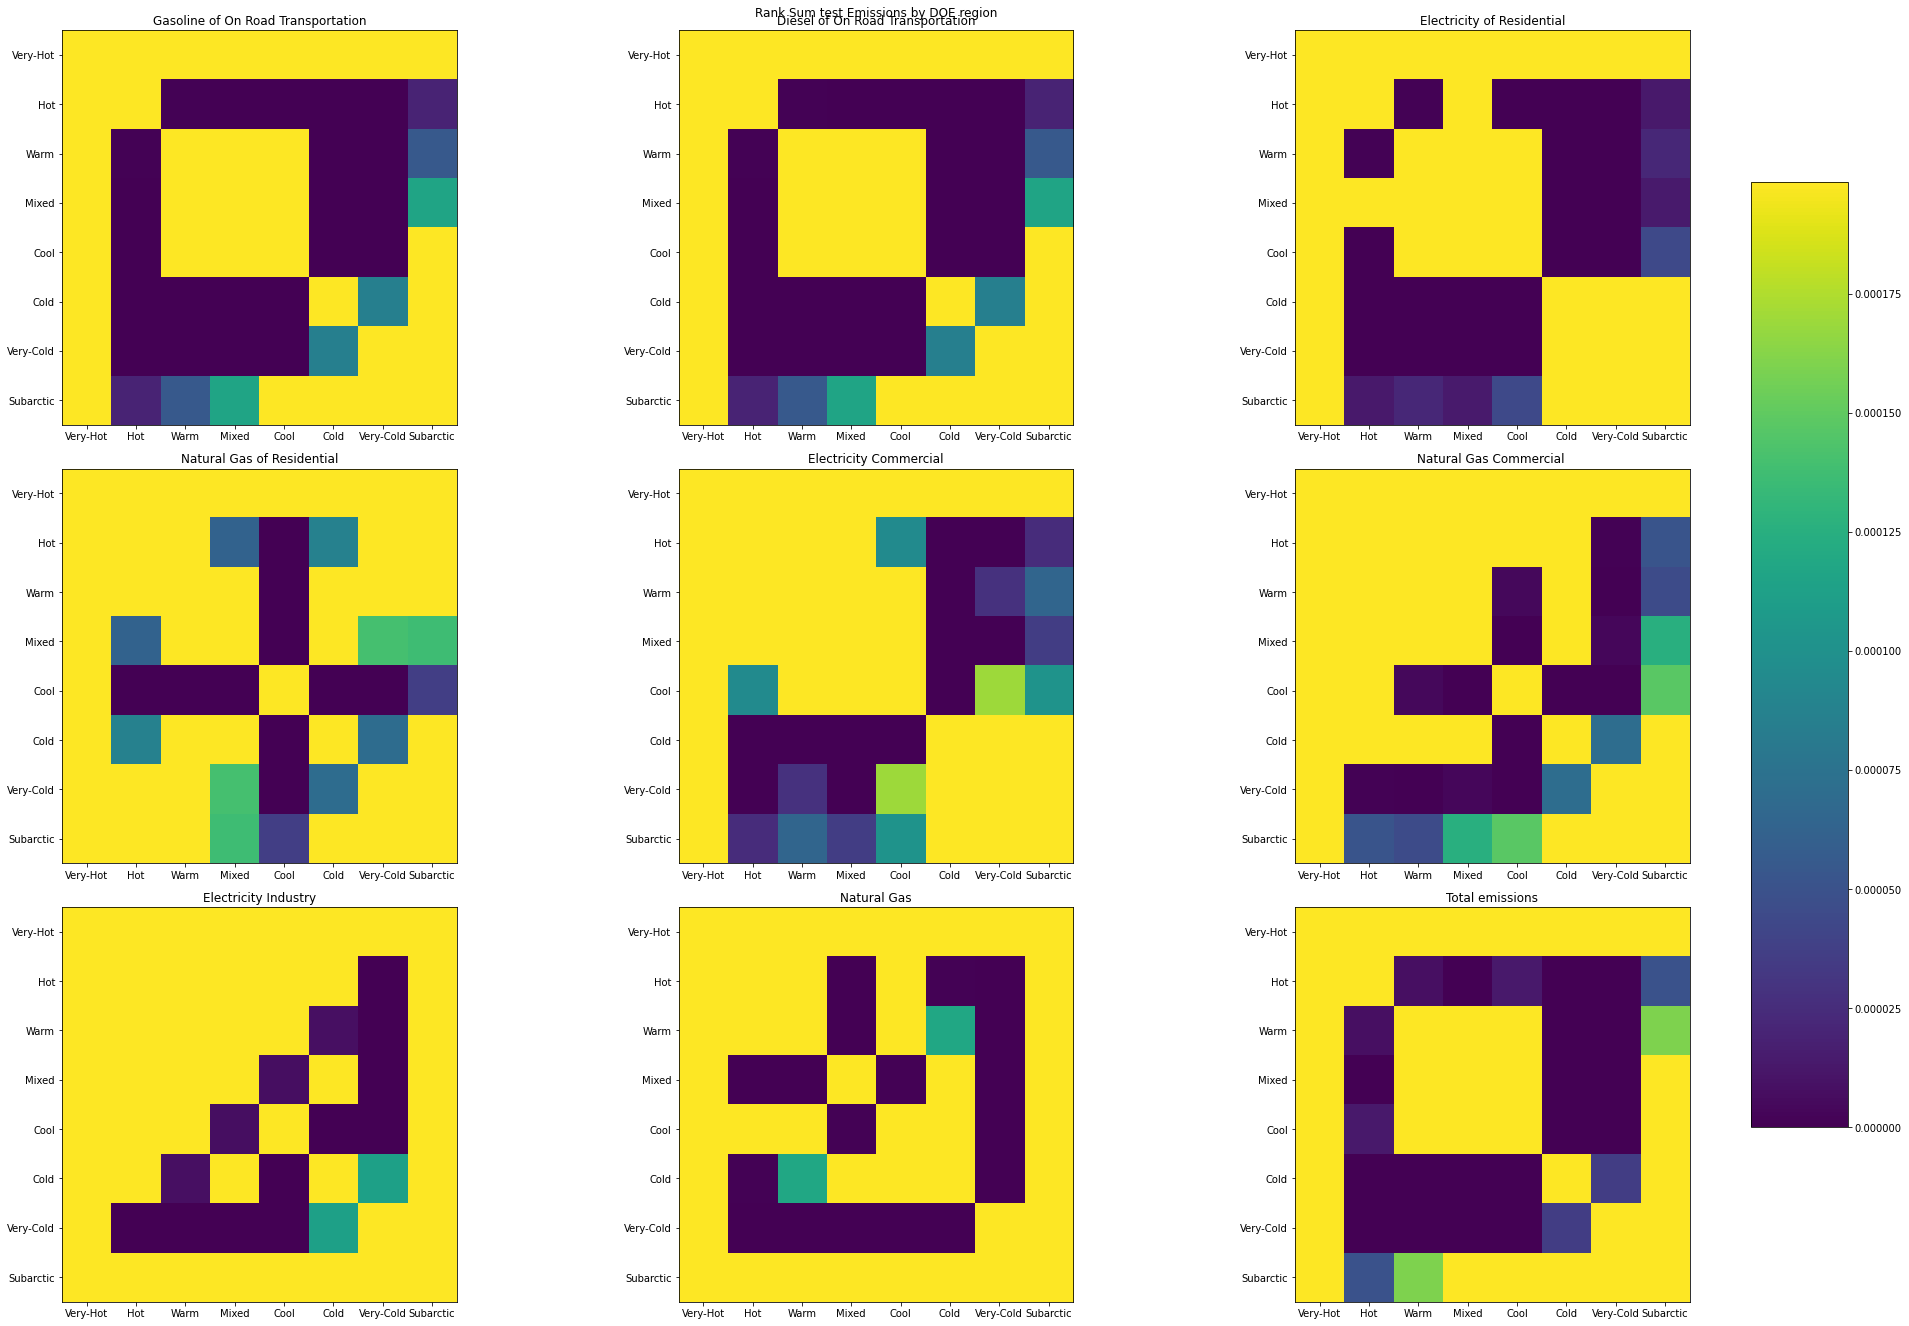

In [ ]:
fig,axes = plt.subplots(3,3,figsize=(9*3,6.25*3))
axes = axes.flatten()
for  idx,(name , icol) in enumerate(col_name_paris): 
    names = list()  
    values = list() 
    values = np.zeros((len(climate_order),len(climate_order)))
    for i,regiona in enumerate(climate_order): 
        for j,regionb in enumerate(climate_order): 
            ra_val = data.loc[data['doe_climate_zone_name']==regiona,icol]
            rb_val = data.loc[data['doe_climate_zone_name']==regionb,icol]
            pval = stats.ranksums(ra_val,rb_val).pvalue
            values[i,j] = pval 
    im = axes[idx].imshow(values, vmin=0, vmax=0.05/( len(col_name_pairs)))
    save_name = name.replace(" ","_")
    axes[idx].set_title(f"{name}")
    # Add labels
    num_labels = len(climate_order) 
    axes[idx].set_xticks(range(num_labels),climate_order) 
    axes[idx].set_yticks(range(num_labels),climate_order)
fig.suptitle("Rank Sum test Emissions by DOE region")
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout()

In [45]:
len(climate_order)

8

In [47]:
climate_orde

NameError: name 'climate_orde' is not defined

In [52]:
0.05/(28*len(expi_cols))

0.00029761904761904765

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


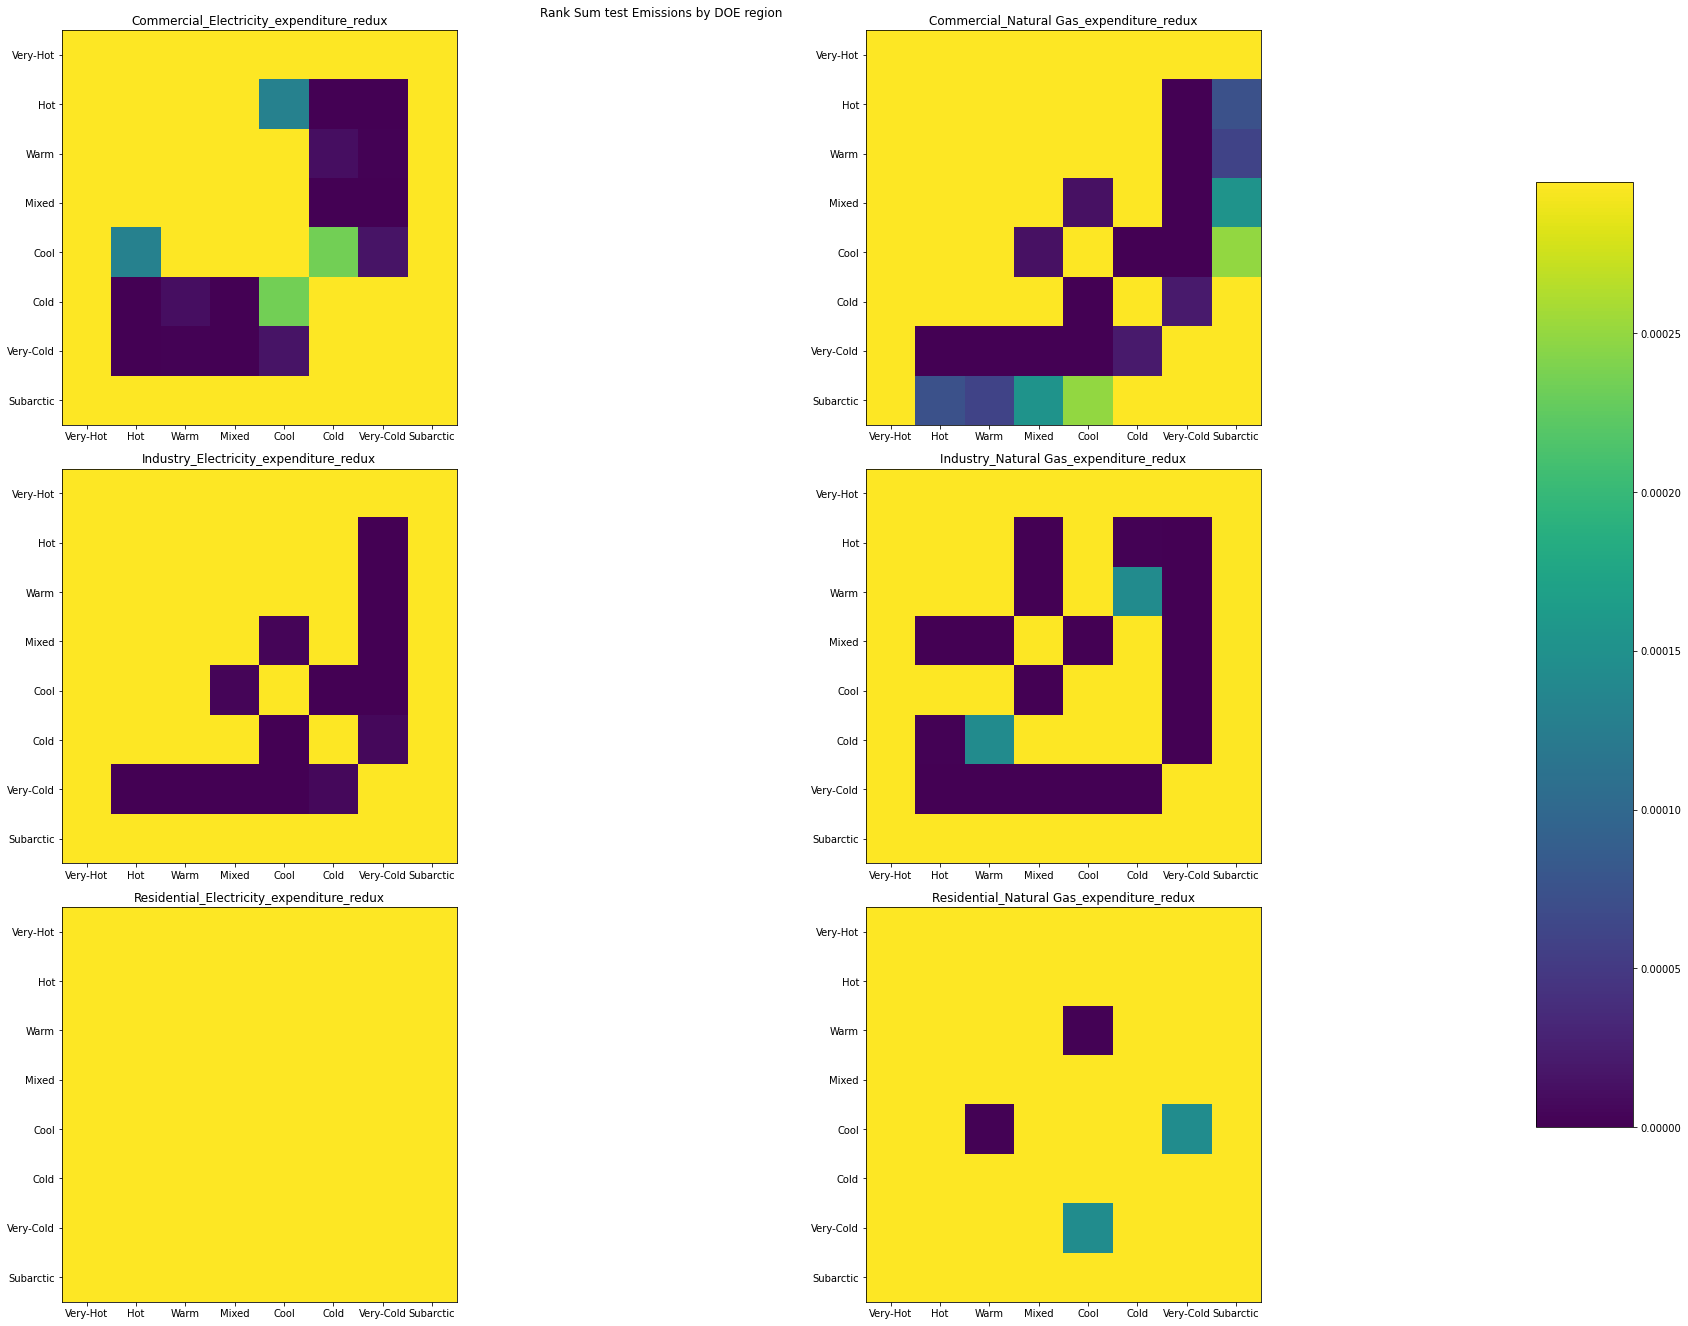

In [51]:
expi_cols = list(expi_d.keys())
fig,axes = plt.subplots(3,2,figsize=(9*3,6.25*3))
axes = axes.flatten()
for  idx,(name ) in enumerate(expi_cols): 
    icol = name
    names = list()  
    values = list() 
    values = np.zeros((len(climate_order),len(climate_order)))
    for i,regiona in enumerate(climate_order): 
        for j,regionb in enumerate(climate_order): 
            ra_val = data.loc[data['doe_climate_zone_name']==regiona,icol]
            rb_val = data.loc[data['doe_climate_zone_name']==regionb,icol]
            pval = stats.ranksums(ra_val,rb_val).pvalue
            values[i,j] = pval 
    im = axes[idx].imshow(values, vmin=0, vmax=0.05/(28*len(expi_cols)))
    save_name = name.replace(" ","_")
    axes[idx].set_title(f"{name}")
    # Add labels
    num_labels = len(climate_order) 
    axes[idx].set_xticks(range(num_labels),climate_order) 
    axes[idx].set_yticks(range(num_labels),climate_order)
fig.suptitle("Rank Sum test Emissions by DOE region")
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout()

In [30]:
consume_names.append("total_consume")

In [33]:
consume_names

['Commercial_Electricity_Consume',
 'Commercial_NaturalGas_Consume',
 'Industrial_Electricity_Consume',
 'Industrial_NaturalGas_Consume',
 'On Road Diesel_Consume',
 'On Road Gasoline_Consume',
 'Residential_Electricity_Consume',
 'Residential_NaturalGas_Consume',
 'total_consume']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


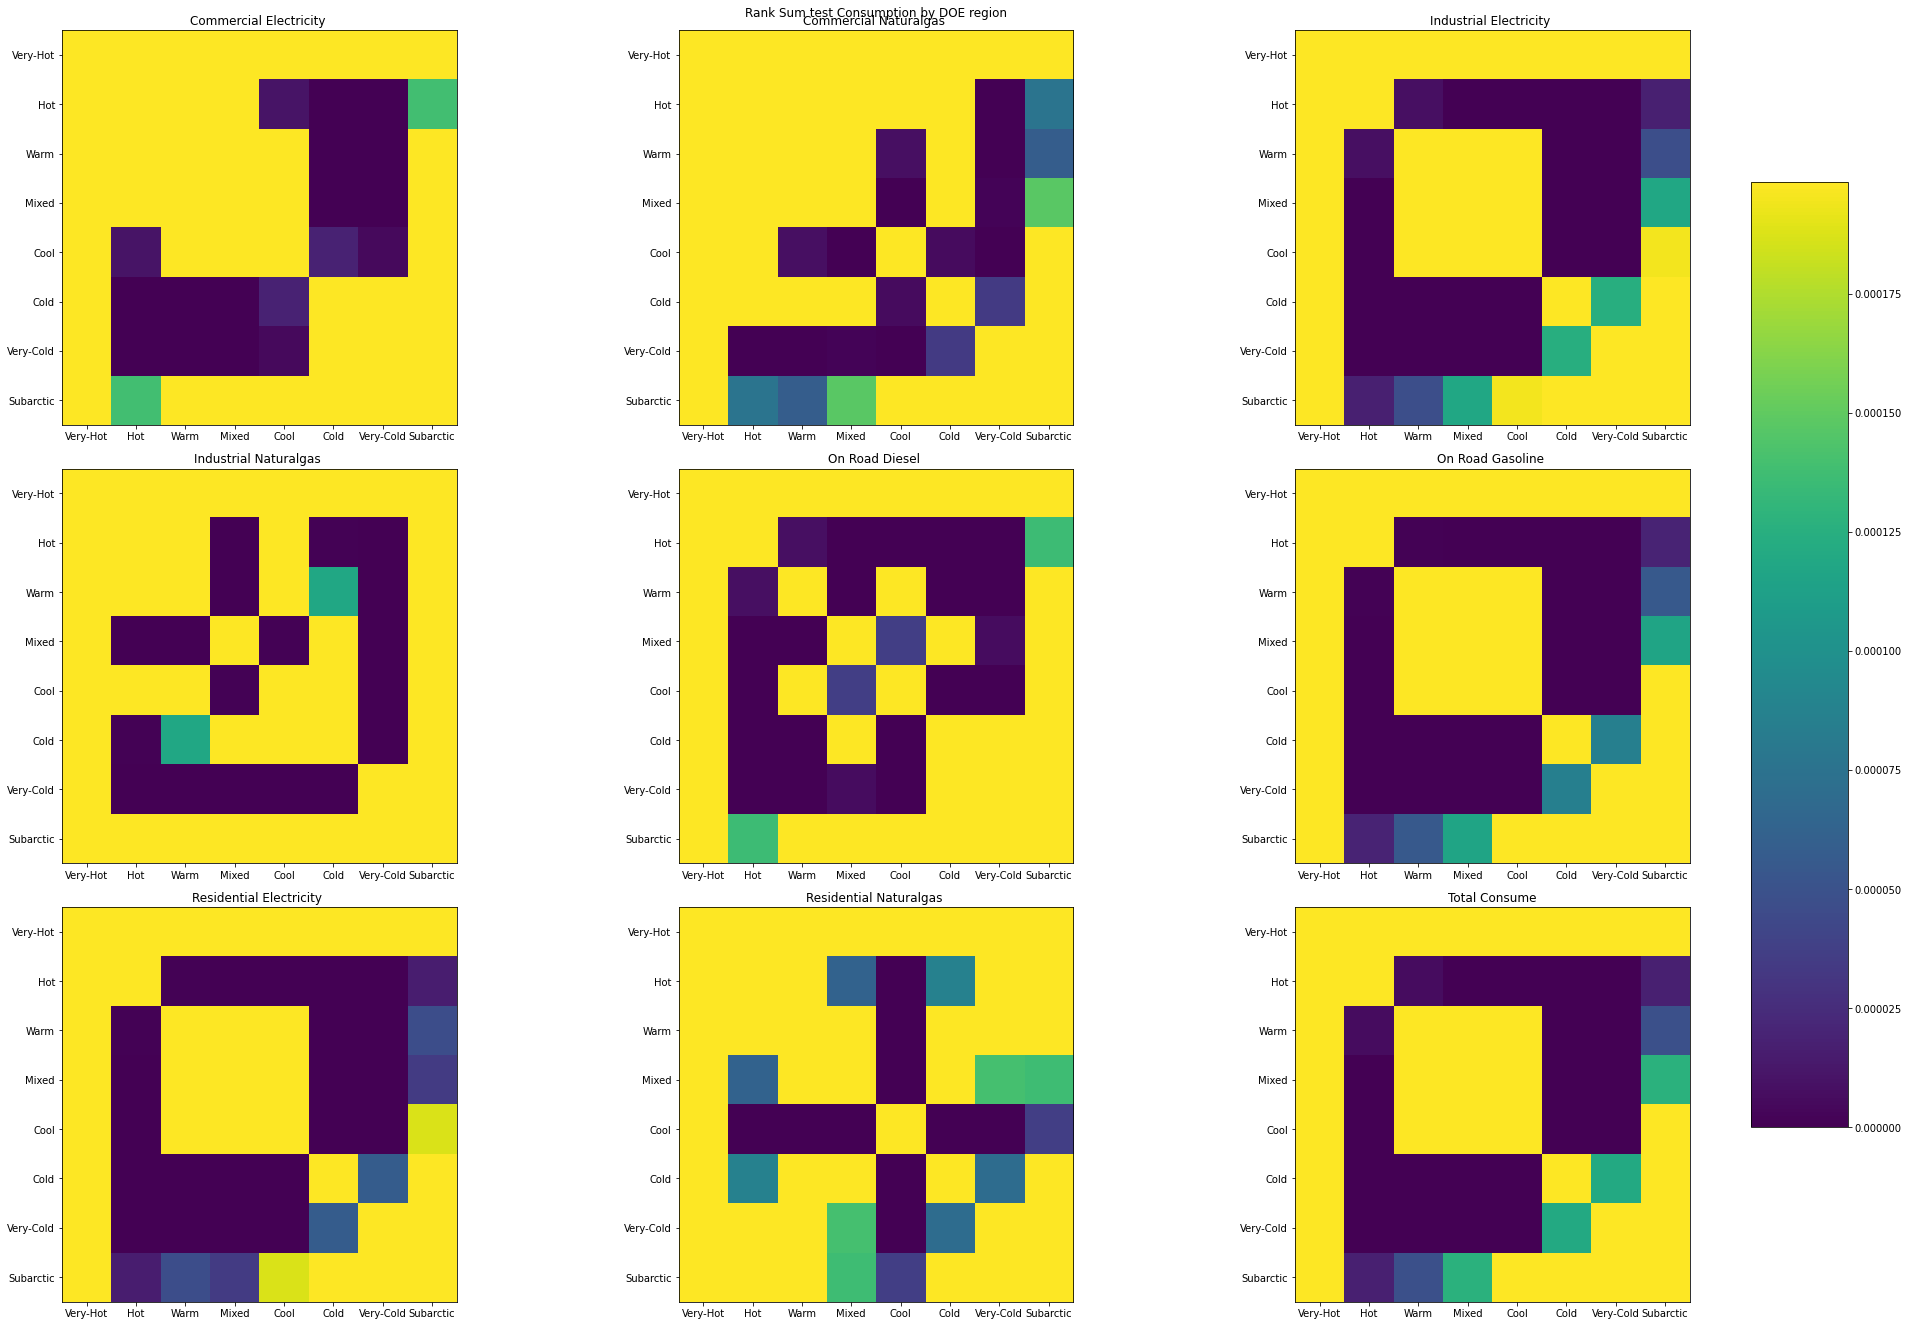

In [32]:

fig,axes = plt.subplots(3,3,figsize=(9*3,6.25*3),)
axes = axes.flatten()
for  idx,(icol) in enumerate(consume_names): 
    name = icol
    names = list()  
    values = list() 
    values = np.zeros((len(climate_order),len(climate_order)))
    for i,regiona in enumerate(climate_order): 
        for j,regionb in enumerate(climate_order): 
            ra_val = data.loc[data['doe_climate_zone_name']==regiona,icol]
            rb_val = data.loc[data['doe_climate_zone_name']==regionb,icol]
            pval = stats.ranksums(ra_val,rb_val).pvalue
            values[i,j] = pval 
    im = axes[idx].imshow(values, vmin=0, vmax=0.05/(28*len(col_name_pairs)))
    save_name = name.replace("_"," ").replace("Consume","")
    axes[idx].set_title(f"{save_name}".title())
    # Add labels
    num_labels = len(climate_order) 
    axes[idx].set_xticks(range(num_labels),climate_order) 
    axes[idx].set_yticks(range(num_labels),climate_order)
fig.suptitle("Rank Sum test Consumption by DOE region")
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout()

In [171]:
os.makedirs("./figure4_consumption/",exist_ok=True)

In [173]:
consume_pairs = [e for e in data if 'consume' in e] 
consume_pairs

['total_consume']

In [135]:
data['emission_norm_pop'] = data['total_emissions']/data['population']

In [136]:
from plot_utils import * 

make_map(data,column='emission_norm_pop',level='county')

In [ ]:
cols = sorted(data.keys())
reduction_paris = [
    ('Commercial_Electricity',  filter_columns(cols,'Commercial_Electricity_consumption')),
    ('Commercial_Natural Gas', filter_columns(cols,'Commercial_Natural Gas_consumption (TcF)')),
    ('Industrial_Electricity',[e for e in cols if filter_columns(cols,'Industry_Electricity_consumption (MWh)')]),
    ('Industrial_Electricity',[e for e in cols if filter_columns(cols,'Industry_Electricity_consumption (MWh)')]) ,
    ("Industrial_NaturalGas",["Industry_Natural Gas_consumption (TcF).3"]),
    ("On Road Diesel_expenditure",['On Road Transportation_Diesel_consumption (gallons).1']),
    ("On Road Gasoline_expenditure",["On Road Transportation_Gasoline_expenditure (gallons)"]),
    ("Residential_Electricity_expenditure",['Residential_Electricity_expenditure (MWh)']),
    ("Residential_NaturalGas_expenditure",['Residential_Natural Gas_expenditure (TcF)']),
    ]
for n,e in reduction_paris: 
    data[n] = data[e].sum(axis=1)